# Relation extraction rule-based method

In [1]:
import re 
import string 
import pandas as pd 
import numpy as np 
import math 
import spacy
from tqdm import tqdm


from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 


nlp = spacy.load("en_core_web_sm")

## Hearst Patterns

In [2]:
#pattern such as
# sample text 
text = "GDP in countries such as Vietnam will continue growing at a high rate."

# create a spaCy object 
doc = nlp(text)

# print token, dependency, POS tag 
for tok in doc: 
  #print(tok.text, "-->",tok.dep_,"-->", tok.pos_)
  if(tok.dep_.find('ROOT')==False):
        print(tok.text)

continue


In [3]:
#define the pattern 
pattern = [{'DEP':'nummod','OP':"?"}, # numeric modifier 
           {'DEP':'compound','OP':"?"},
           {'DEP':'amod', 'OP':"?"},# adjectival modifier
           {'POS':'NOUN'}, 
           {'LOWER': 'such'}, 
           {'LOWER': 'as'},
           {'DEP':'nummod','OP':"?"},
           {'DEP':'compound','OP':"?"},
           {'DEP':'amod', 'OP':"?"},
           {'POS': 'PROPN'}]
# Matcher class object 
matcher = Matcher(nlp.vocab) 
matcher.add("matching_1",[pattern]) 

matches = matcher(doc) 
span = doc[matches[0][1]:matches[0][2]] 

print(span)

countries such as Vietnam


In [4]:
#we can set many rules like
#define the pattern 
pattern = [
    [{'DEP':'nummod','OP':"?"},{'DEP':'compound','OP':"?"},{'DEP':'amod', 'OP':"?"},{'POS':'NOUN'}, {'LOWER': 'such'}, {'LOWER': 'as'},{'DEP':'nummod','OP':"?"},{'DEP':'compound','OP':"?"},{'DEP':'amod', 'OP':"?"},{'POS': 'PROPN'}],
    [{'DEP':'amod', 'OP':"?"}, {'POS':'NOUN'}, {'LOWER': 'and', 'OP':"?"}, {'LOWER': 'or', 'OP':"?"},  {'LOWER': 'other'}, {'POS': 'NOUN'}],
    [{'DEP':'nummod','OP':"?"},{'DEP':'amod','OP':"?"}, {'POS':'NOUN'}, {'IS_PUNCT': True}, {'LOWER': 'including'}, {'DEP':'nummod','OP':"?"}],
    [{'DEP':'nummod','OP':"?"},{'DEP':'amod','OP':"?"}, {'POS':'NOUN'}, {'IS_PUNCT': True}, {'LOWER': 'including'}, {'DEP':'nummod','OP':"?"}, {'DEP':'amod','OP':"?"}, {'POS':'NOUN'}],
    [{'DEP':'nummod','OP':"?"},{'DEP':'amod','OP':"?"}, {'POS':'NOUN'}, {'IS_PUNCT':True}, {'LOWER': 'especially'}, {'DEP':'nummod','OP':"?"}, {'DEP':'amod','OP':"?"}, {'POS':'NOUN'}],
]
matcher.add("Hearst Patterns", pattern)
doc = nlp("Here is how you can keep your car and other vehicles clean.")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(span.text)

car and other vehicles


<font color= red>Different sentence structure may correspond to different patterns or rules because of the verbs, structure of sentences and so on. There may be thousand of rules. </font>

## subtree matching

In [8]:
# Plot the dependency graph 
from pathlib import Path
doc = nlp(text) 
svg = displacy.render(doc, style='dep',jupyter=False)
output_path = Path("dependency_plot.svg") # you can keep there only "dependency_plot.svg" if you want to save it in the same folder where you run the script 
output_path.open("w", encoding="utf-8").write(svg)

10541

In [6]:
displacy.render(nlp('The good girl are fired by the boss'), style='dep',jupyter=True)

In [7]:
import networkx as nx
import matplotlib.pyplot as plt 

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G,pos, edge_color='black',width=3, linewidths=0,
            node_size=100, node_color='red',alpha=0.6)
    nx.draw_networkx_labels(G,pos, font_size=8)
    plt.axis('off')
    plt.show()

In [8]:
def subtree_matcher(doc):
    subjpass = 0

    for i,tok in enumerate(doc):
        
    # find dependency tag that contains the text "subjpass"    
       if tok.dep_.find("subjpass") == True:
            subjpass = 1

    x = ''
    y = ''
    z = ''

  # if subjpass == 1 then sentence is passive
    if subjpass == 1:
        for i,tok in enumerate(doc):
            if tok.dep_.find("subj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    y = doc[i-1].text + ' '+tok.text
                else:
                    y=tok.text
                                   
            if(tok.dep_.find('ROOT')==0):
                z=tok.text
                
            if tok.dep_.endswith("obj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    x = doc[i-1].text + ' '+tok.text  
                else:
                    x = tok.text
  
  # if subjpass == 0 then sentence is not passive
    else:
        for i,tok in enumerate(doc):
            if tok.dep_.endswith("subj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    x = doc[i-1].text + ' '+tok.text 
                else:
                    x = tok.text
                    
            if(tok.dep_.find('ROOT')==0):
                z=tok.text

            if tok.dep_.endswith("obj") == True:
                if(doc[i-1].dep_ in['amod','compound']):
                    y = doc[i-1].text + ' '+tok.text
                else:
                    y = tok.text

    return x,y,z

In [9]:
subtree_matcher(nlp('The smart girl are fired by the shitty boss'))
subtree_matcher(nlp("The GDP in countries such as Vietnam will continue growing at a high rate."))

('GDP', 'high rate', 'continue')

In [10]:
import json
import nltk

def getText():
    f = open('../data/texts.json',)
    data = json.load(f)
    content_debates = data['debates']
    #text= content_debates.replace("\n"," ")
    return content_debates


def getSentences(text):
    document = nlp(text)
    return [sent.text for sent in document.sents]

In [11]:
sentences = getSentences(getText())
for sentence in sentences[0:10:]:
    print(sentence)
    print("-----------------------------------------------------")
    print(subtree_matcher(nlp(sentence)))

 Good evening from Hofstra University in Hempstead, New York.
-----------------------------------------------------
('', 'Hempstead', ' ')
I am Lester Holt, anchor of "NBC Nightly News.”
-----------------------------------------------------
('I', 'Nightly News', 'am')
I want to welcome you to the first presidential debate.
-----------------------------------------------------
('I', 'presidential debate', 'want')


-----------------------------------------------------
('', '', '\n')
The participants tonight are Donald Trump and Hillary Clinton.
-----------------------------------------------------
('participants', '', 'are')
This debate is sponsored by the Commission on Presidential Debates, a nonpartisan, nonprofit organization.
-----------------------------------------------------
('Presidential Debates', 'debate', 'sponsored')
The commission drafted tonight's format, and the rules have been agreed to by the campaigns.

-----------------------------------------------------
('campaigns

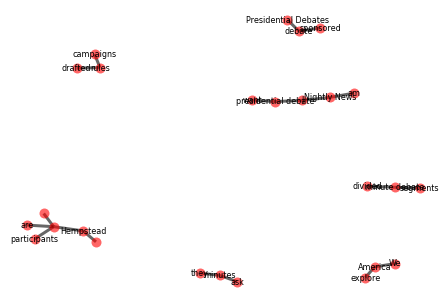

In [12]:
triples = []
for sentence in sentences[0:10:]:
    sen=nlp(sentence)
    triples.append(subtree_matcher(sen))

printGraph(triples)

In [13]:
displacy.render(nlp('Good evening from Hofstra University in Hempstead, New York.'), style='dep',jupyter=True)
doc1= nlp('Good evening from Hofstra University in Hempstead, New York.')

In [14]:
#we can extract the Noun phrase
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
for entity in doc.ents:
    print(entity.text, entity.label_)

Noun phrases: ['GDP', 'countries', 'Vietnam', 'a high rate']
Verbs: ['continue', 'grow']
Vietnam GPE


## chunk and name entity to extract the relation

In [15]:
def appendChunk(original, chunk):
    return original + ' ' + chunk

def printToken(token):
    print(token.text, "->", token.dep_)

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)


def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        #printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

In [16]:
i1= nlp('AA is the founder of that charity')
processSubjectObjectPairs(i1)

AA , be founder , charity


('AA', 'be founder', 'charity')

 , good , University Hempstead
I , be Holt , News
I , want first presidential , you debate
 ,  , 
participants , be Trump , 
debate , sponsor by nonpartisan nonprofit , Commission Debates
commission rules , draft by , format campaigns
debate , divide , segments
We , explore , areas prosperity direction America
I they , ask same lead , start segment question candidates minutes


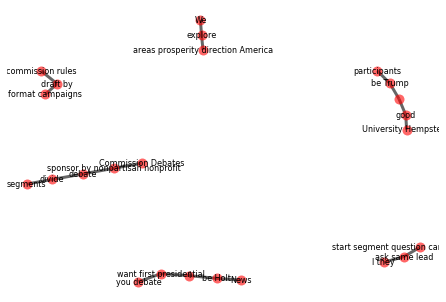

In [17]:
triples1 = []
for sentence in sentences[0:10:]:
    sen=nlp(sentence)
    triples1.append(processSubjectObjectPairs(sen))

printGraph(triples1)

In [18]:
test ="London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."
t = getSentences(test)
for sentence in t:
    print(sentence)
    sen=nlp(sentence)
    processSubjectObjectPairs(sen)
    print('\n')

London is the capital and largest city of England and the United Kingdom.
London , be capital large , England


Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia.
London , be major settlement , Thames east England head km Sea millennia


Londinium was founded by the Romans.
Londinium , found by , Romans


The City of London, London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits.
City that , ancient square retain medieval , London miles − boundaries limits


The City of Westminster is also an Inner London borough holding city status.
City , be hold status , Westminster


Greater London is governed by the Mayor of London and the London Assembly.
London , govern by , Mayor London


London is located in the southeast of England.
London , locate ,

London , be capital large , England
London , be major settlement , Thames east England head km Sea millennia
Londinium , found by , Romans
City that , ancient square retain medieval , London miles − boundaries limits
City , be hold status , Westminster
London , govern by , Mayor London
London , locate , southeast England
Westminster , locate , London
London , be big city , Britain
London , have , population 7,172,036


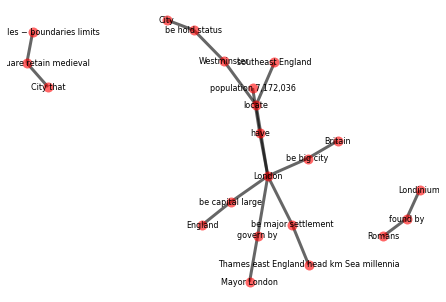

In [19]:
triples2 = []
for sentence in t:
    sen=nlp(sentence)
    triples2.append(processSubjectObjectPairs(sen))

printGraph(triples2)

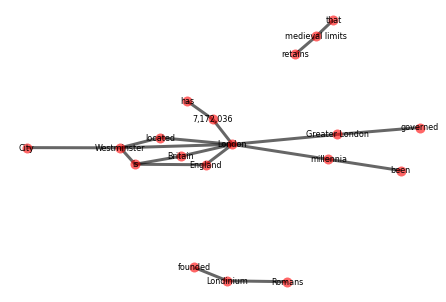

In [20]:
triples3 = []
for sentence in t:
    sen=nlp(sentence)
    triples3.append(subtree_matcher(sen))

printGraph(triples3)

In [45]:
#Next step:get all relationship, calculate the frequency of two entity which appear in one sentences, extract all those relation.
import spacy
from spacy.matcher import DependencyMatcher

nlp = spacy.load("en_core_web_sm")
matcher = DependencyMatcher(nlp.vocab)

pattern = [
    {
        "RIGHT_ID": "anchor_founded",
        "RIGHT_ATTRS": {"ORTH": "founded"}
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object",
        "RIGHT_ATTRS": {"DEP": "dobj"},
    },
    {
        "LEFT_ID": "founded_object",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object_modifier",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "compound"]}},
    }
]

matcher.add("F", [pattern])
doc = nlp("Lee, an experienced CEO, has founded two AI startups.")
matches = matcher(doc)

print(matches) # [(4851363122962674176, [6, 0, 10, 9])]
# Each token_id corresponds to one pattern dict
match_id, token_ids = matches[0]
for i in range(len(token_ids)):
    print(pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)

In [ ]:
#Next step: calculate the vector of entities in one sentences and their similarity to extract the relationship
#resinik similarity
#找到每句话中的实体，用resinik similarity 计算其距离，设置距离的大小为某一类，然后做一个关系的分类
#https://gsi-upm.github.io/sematch/similarity/